In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def pos(x):
    y = x.copy()
    y[x > 0] = x[x > 0]
    y[x <= 0] = 0
    return y


def basis(i, x, h, x_0):
    a = pos((x - x_0) / h - (i - 2)) ** 3
    b = 4 * pos((x - x_0) / h - (i - 1)) ** 3
    c = 6 * pos((x - x_0) / h - (i - 0)) ** 3
    d = 4 * pos((x - x_0) / h - (i + 1)) ** 3
    e = pos((x - x_0) / h - (i + 2)) ** 3

    f = 0.25 * (a - b + c - d + e)

    return f

### Define theregular grid

In [3]:
x0 = 0
xN = 1

y0 = 0
yN = 1

Nx = 28
Ny = 28

X, h_1 = np.linspace(x0, xN, Nx, retstep=True)
Y, h_2 = np.linspace(y0, yN, Ny, retstep=True)

In [4]:
x = np.linspace(x0 - 2 * h_1, xN + 2 * h_1, 1000)
y = np.linspace(y0 - 2 * h_2, yN + 2 * h_2, 1000)
IX, IY = np.meshgrid(X, Y, indexing="xy")

n_points_x = X.shape[0]
n_points_y = Y.shape[0]

### Computed integrals

In [5]:
x_axis_xx = np.array(
    [
        3 / 8 / h_1**4,
        0,
        -27 / 8 / h_1**4,
        6 / h_1**4,
        -27 / 8 / h_1**4,
        0,
        3 / 8 / h_1**4,
    ]
)
y_axis_xx = np.array(
    [1 / 2240, 3 / 56, 1991 / 2240, 151 / 140, 1991 / 2240, 3 / 56, 1 / 2240]
)

In [6]:
x_axis_yy = np.array(
    [1 / 2240, 3 / 56, 1991 / 2240, 151 / 140, 1991 / 2240, 3 / 56, 1 / 2240]
)
y_axis_yy = np.array(
    [
        3 / 8 / h_2**4,
        0,
        -27 / 8 / h_2**4,
        6 / h_2**4,
        -27 / 8 / h_2**4,
        0,
        3 / 8 / h_2**4,
    ]
)

In [7]:
x_axis_xy = np.array(
    [
        -3 / 160 / h_1**2,
        -9 / 20 / h_1**2,
        -9 / 32 / h_1**2,
        3 / 2 / h_1**2,
        -9 / 32 / h_1**2,
        -9 / 20 / h_1**2,
        -3 / 160 / h_1**2,
    ]
)
y_axis_xy = np.array(
    [
        -3 / 160 / h_2**2,
        -9 / 20 / h_2**2,
        -9 / 32 / h_2**2,
        3 / 2 / h_2**2,
        -9 / 32 / h_2**2,
        -9 / 20 / h_2**2,
        -3 / 160 / h_2**2,
    ]
)

In [8]:
weights = np.array([1 / 4, 1, 1 / 4])
right_integrals_x = np.array([531 / 1120, 151 / 140, 531 / 1120]) * h_1
right_integrals_y = np.array([531 / 1120, 151 / 140, 531 / 1120]) * h_2
right_integrals = np.outer(right_integrals_y * weights, right_integrals_x * weights)

In [9]:
xx = np.outer(x_axis_xx, y_axis_xx)
xy = np.outer(x_axis_xy, y_axis_xy)
yy = np.outer(x_axis_yy, y_axis_yy)
right = xx + 2 * xy + yy

### Assemble the stiffness matrix

In [10]:
matrix = np.zeros((n_points_y * n_points_x, n_points_y * n_points_x))
b = np.zeros(n_points_y * n_points_x)
f = np.ones_like(IX)

for i in range(n_points_y * n_points_x):
    idx = np.unravel_index(i, (n_points_y, n_points_x))
    tmp = np.zeros((n_points_y, n_points_x))

    i_sl_b, i_sl_e = max(0, idx[0] - 3), min(idx[0] + 4, n_points_y)
    j_sl_b, j_sl_e = max(0, idx[1] - 3), min(idx[1] + 4, n_points_x)

    if (idx[0] >= 3) and (idx[0] <= n_points_y - 4):
        ri_sl_b = 0
    elif idx[0] < 3:
        ri_sl_b = 3 - idx[0]
    else:
        ri_sl_b = 0

    if (idx[0] >= 3) and (idx[0] <= n_points_y - 4):
        ri_sl_e = 7
    elif idx[0] < 3:
        ri_sl_e = 7
    else:
        ri_sl_e = n_points_y - idx[0] + 3

    if (idx[1] >= 3) and (idx[1] <= n_points_x - 4):
        rj_sl_b = 0
    elif idx[1] < 3:
        rj_sl_b = 3 - idx[1]
    else:
        rj_sl_b = 0

    if (idx[1] >= 3) and (idx[1] <= n_points_x - 4):
        rj_sl_e = 7
    elif idx[1] < 3:
        rj_sl_e = 7
    else:
        rj_sl_e = n_points_x - idx[1] + 3

    tmp[i_sl_b:i_sl_e, j_sl_b:j_sl_e] = (
        2 * right[ri_sl_b:ri_sl_e, rj_sl_b:rj_sl_e] * h_1 * h_2
    )

    matrix[i] = tmp.flatten()

    if 0 < idx[0] < n_points_y - 1:
        ri_b = 0
        ri_e = 3
    elif idx[0] == 0:
        ri_b = 1
        ri_e = 3
    elif idx[0] == n_points_y - 1:
        ri_b = 0
        ri_e = 2

    if 0 < idx[1] < n_points_x - 1:
        rj_b = 0
        rj_e = 3
    elif idx[1] == 0:
        rj_b = 1
        rj_e = 3
    elif idx[1] == n_points_x - 1:
        rj_b = 0
        rj_e = 2

    b[i] = 2 * right_integrals[ri_b:ri_e, rj_b:rj_e].sum()

### Solve the system

In [11]:
C = np.linalg.solve(matrix, b).reshape(n_points_y, n_points_x)

In [12]:
xx, yy = np.meshgrid(x, y, indexing="ij")
zz = np.zeros_like(xx)

In [13]:
for i in tqdm(range(IY.shape[0])):
    for j in range(IX.shape[1]):
        y_part = basis(i, y, h_2, y0)
        x_part = basis(j, x, h_1, x0)
        zz = zz + C[i, j] * np.outer(x_part, y_part)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.91it/s]


### Solution plot

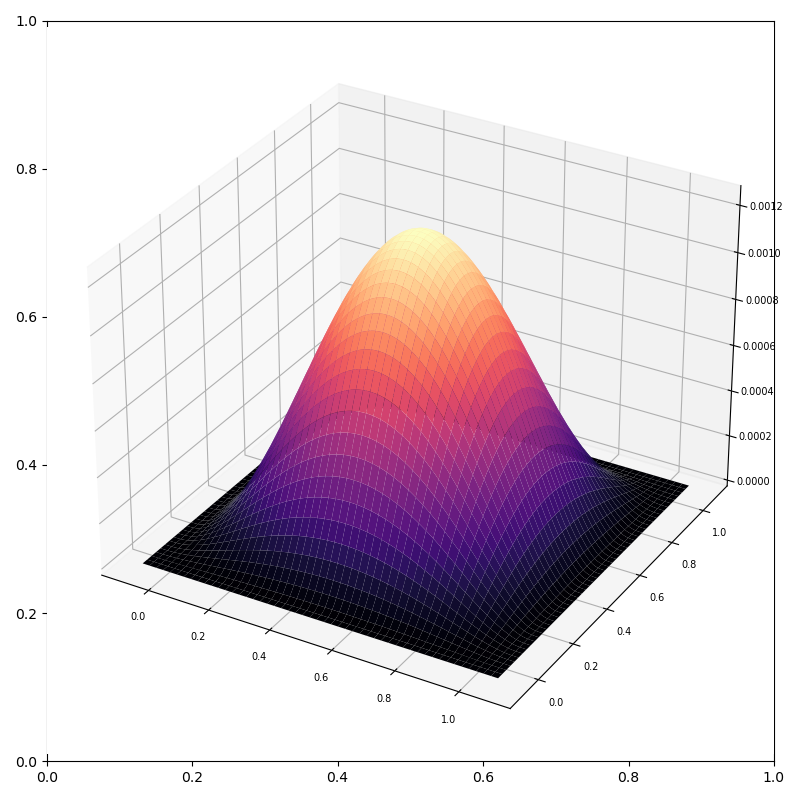

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(xx, yy, zz, cmap="magma")
ax.tick_params(axis="both", which="major", labelsize=7)
fig.tight_layout()
plt.show()